In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


<br> In this notebook:

<p> 1) <b> Continue with Logistic Regression </b>
<p>  -undersampling rookies > 5 years
<p>  -oversampling rookies < 5 years
<p>  -removing correlated features
<p>  -dealing with negative values

<br> 2)<b> Gradient boosting </b>

<br> 3)<b> XGB model </b>



In [160]:
#get the training dataset and drop the id
df=pd.read_csv('../data/raw/train.csv')
df_analysis=df.drop(columns=["Id_old","Id"])

In [161]:
#Pop into a new variable the target column
target = df_analysis.pop('TARGET_5Yrs')

<b> 1) Logistic Regression - continued </b>

In [162]:
#scale the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled= scaler.fit_transform(df_analysis)

In [163]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split (df_scaled, target, test_size=0.2, random_state=8)

The graph below shows that the training dataset is dominated by rookies who make it pass 5 years 

<AxesSubplot:xlabel='TARGET_5Yrs', ylabel='count'>

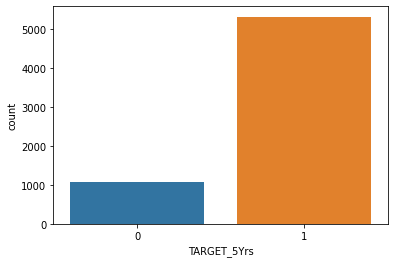

In [164]:
#plot the training dataset
#y_train.head()
sns.countplot(x="TARGET_5Yrs",data=pd.DataFrame(y_train))

We will balance the data by undersampling from rookies who make it past 5 years

In [165]:
from sklearn.utils import resample
imbalanced_X = X_train
imbalanced_Y = y_train

In [166]:
#Sampling the number of y=0 from subset where y=1
undersampled_X, undersampled_Y = resample(imbalanced_X[imbalanced_Y==1], imbalanced_Y[imbalanced_Y==1],replace=True,
                n_samples=imbalanced_X[imbalanced_Y==0].shape[0],
                random_state=123)

In [167]:
#Create new balanced training set - combine with Y=0
balanced_X_1 = np.vstack((imbalanced_X[imbalanced_Y==0],undersampled_X))
balanced_Y_1 = np.hstack((imbalanced_Y[imbalanced_Y==0],undersampled_Y))

<AxesSubplot:xlabel='TARGET_5Yrs', ylabel='count'>

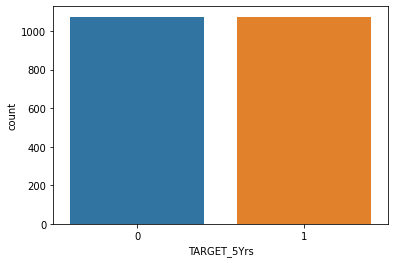

In [168]:
#plot the new training set
sns.countplot(x="TARGET_5Yrs",data=pd.DataFrame(balanced_Y_1).rename(columns={0:"TARGET_5Yrs"}))

There are now ~1000 records in both categories in the dataset

In [169]:
#Model new balanced dataset
from sklearn.linear_model import LogisticRegression
model_undersample=LogisticRegression(penalty = 'none')
model_undersample.fit(balanced_X_1, balanced_Y_1)
model_undersample.predict(X_valid)

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

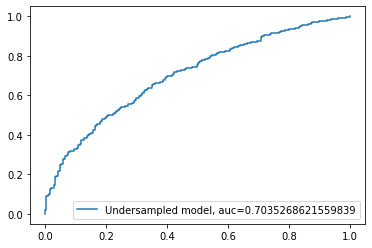

In [268]:
#get the AOC metric and plot the curve
from sklearn import metrics

y_pred_proba_u = model_undersample.predict_proba(X_valid)[::,1]
fpr_u, tpr_u, _ = metrics.roc_curve(y_valid,  y_pred_proba_u)
auc_undersample = metrics.roc_auc_score(y_valid, y_pred_proba_u)
plt.plot(fpr_u,tpr_u,label="Undersampled model, auc="+str(auc_undersample))
plt.legend(loc=4)
plt.show()

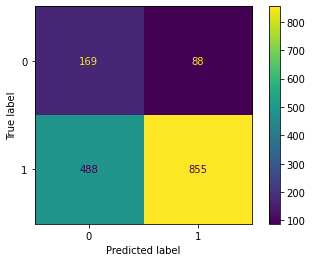

In [269]:
y_undersample_predict =model_undersample.predict(X_valid)
cm_under= confusion_matrix(y_valid, y_undersample_predict, labels=model_undersample.classes_)

disp_under = ConfusionMatrixDisplay(confusion_matrix=cm_under, display_labels=model_undersample.classes_)
disp_under.plot()

Undersampling also resulted in AOC ~.70, just like the imbalanced dataset

It is now correctly predicting Y=0 65% the time and Y=1 64% of the time

Now going to try oversampling from Y=0

In [270]:
#Oversampling the number of y=0 so that it matches the number of Y=1
oversampled_X, oversampled_Y = resample(imbalanced_X[imbalanced_Y==0], imbalanced_Y[imbalanced_Y==0],replace=True,
                n_samples=imbalanced_X[imbalanced_Y==1].shape[0],
                random_state=123)

In [271]:
#Create new balanced training set
balanced_X_2 = np.vstack((imbalanced_X[imbalanced_Y==1],oversampled_X))
balanced_Y_2 = np.hstack((imbalanced_Y[imbalanced_Y==1],oversampled_Y))

<AxesSubplot:xlabel='TARGET_5Yrs', ylabel='count'>

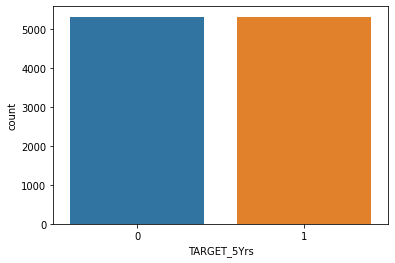

In [272]:
#plot the new training set
sns.countplot(x="TARGET_5Yrs",data=pd.DataFrame(balanced_Y_2).rename(columns={0:"TARGET_5Yrs"}))

The number of Y=0 and Y=1 are now both ~5000

In [273]:
#Model new balanced dataset

from sklearn.linear_model import LogisticRegression
model_oversample=LogisticRegression(penalty = 'none')
model_oversample.fit(balanced_X_2, balanced_Y_2)
model_oversample.predict(X_valid)

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

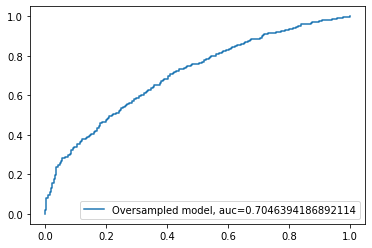

In [274]:
#get the AOC metric and plot the curve
from sklearn import metrics

y_pred_proba_o = model_oversample.predict_proba(X_valid)[::,1]
fpr_o, tpr_o, _ = metrics.roc_curve(y_valid,  y_pred_proba_o)
auc_oversample = metrics.roc_auc_score(y_valid, y_pred_proba_o)
plt.plot(fpr_o,tpr_o,label="Oversampled model, auc="+str(auc_oversample))
plt.legend(loc=4)
plt.show()

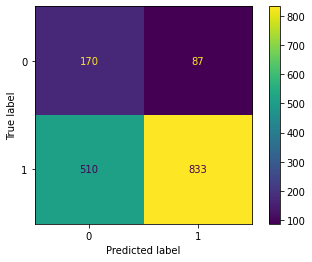

In [275]:
y_oversample_predict =model_oversample.predict(X_valid)
cm_over = confusion_matrix(y_valid, y_oversample_predict, labels=model_oversample.classes_)

disp_over= ConfusionMatrixDisplay(confusion_matrix=cm_over, display_labels=model_oversample.classes_)
disp_over.plot()

Just like undersampling, oversampling also produced AUC of ~.70

It is now correctly predicting Y=0 66% of the time and Y=1 62% of the time.

So oversampling and undersampling does not appear to make a difference on the AUC metric

But they do improve the prediction on Y=0

Undersampling appeared to perform better than oversampling, as it correctly predicted Y=0 and Y=1 at around the same rate

<i> Accounting for highly correlated features </i>

<p>From the results of Assignment 1, it appeared that features that were highly correlated had weak coeffiecient values.
They were:
    
- FGM and FGA (highly correlated with FG%)
- 3P Made and 3PA (highly correlated with 3P%)
- FTM and FTA (highly correlated with FT%)
- REB (highly correlated with OREB and DREB)

In [276]:
#Create new dataset to remove highly correlated features
df_analysis_reduce = df_analysis.drop(columns=["FGM","FGA","3P Made","3PA","FTM","FTA","REB"])
df_scaled_reduce = scaler.fit_transform(df_analysis_reduce)

In [277]:
X_train_reduce, X_valid_reduce, y_train_reduce, y_valid_reduce = train_test_split (df_scaled_reduce, target, test_size=0.2, random_state=8)

#We are going to undersample
imbalanced_X_reduce = X_train_reduce
imbalanced_Y_reduce = y_train_reduce

#Sampling the number of y=0 from subset where y=1
undersampled_X_reduce, undersampled_Y_reduce = resample(imbalanced_X_reduce[imbalanced_Y_reduce==1], imbalanced_Y_reduce[imbalanced_Y_reduce==1],replace=True,
                n_samples=imbalanced_X_reduce[imbalanced_Y_reduce==0].shape[0],
                random_state=123)

#Create new balanced training set - combine with Y=0
balanced_X_reduce = np.vstack((imbalanced_X_reduce[imbalanced_Y_reduce==0],undersampled_X_reduce))
balanced_Y_reduce = np.hstack((imbalanced_Y_reduce[imbalanced_Y_reduce==0],undersampled_Y_reduce))

In [278]:
model_new_reduce=LogisticRegression(penalty = 'none')
model_new_reduce.fit(balanced_X_reduce, balanced_Y_reduce)
model_new_reduce.predict(X_valid_reduce)

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

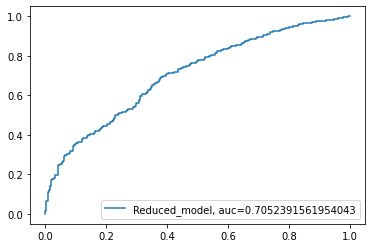

In [349]:
y_pred_proba_reduce = model_new_reduce.predict_proba(X_valid_reduce)[::,1]
fpr_r, tpr_r, _ = metrics.roc_curve(y_valid_reduce,  y_pred_proba_reduce)
auc_reduce = metrics.roc_auc_score(y_valid_reduce, y_pred_proba_reduce)
plt.plot(fpr_r,tpr_r,label="Reduced_model, auc="+str(auc_reduce))
plt.legend(loc=4)
plt.show()

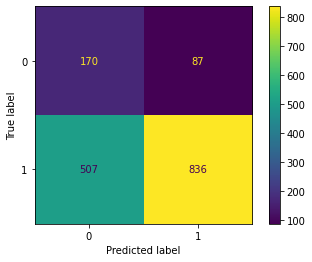

In [280]:
y_reduce_predict =model_new_reduce.predict(X_valid_reduce)
cm_r = confusion_matrix(y_valid_reduce, y_reduce_predict, labels=model_new_reduce.classes_)

dis_r= ConfusionMatrixDisplay(confusion_matrix=cm_r, display_labels=model_new_reduce.classes_)
dis_r.plot()

<AxesSubplot:>

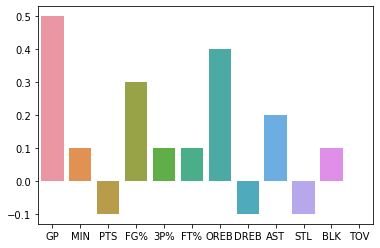

In [281]:
#Grab the coeefficients
np.round(model_new_reduce.coef_,1)
model_new_coef = pd.DataFrame(np.round(model_new_reduce.coef_,1), columns=df_analysis_reduce.columns)
sns.barplot(data=model_new_coef)

Removing the highly correlated features slightly improved AUC metric performance, but AUC metric still around ~0.70-0.71

<i> Dealing with negative values </i>

There are negative values in some of the features like 3PA, BLK, and FT%
These are clearly mislabeled data points as we would expect positive count values for these statistics.

We will replace the negative values with the median for the affected features

In [282]:
df_neg_removed = df_analysis

#split into training and validation set
X_train_negrm, X_valid_negrm, y_train_negrm, y_valid_negrm = train_test_split (df_neg_removed, target, test_size=0.2, random_state=8)

median_values = X_train_negrm.median()
X_train_negrm = X_train_negrm.mask(X_train_negrm < 0, median_values, axis=1)
X_train_negrm.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.0000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000
mean,62.776250,18.559484,7.247859,2.796875,6.212172,44.6030,0.380156,1.116172,22.555188,1.390953,1.945859,71.366500,1.082422,2.169641,3.250609,1.627563,0.649578,0.342609,1.258797
std,17.028302,8.909862,4.296378,1.682254,3.566922,6.1691,0.265392,0.741722,12.784835,0.923136,1.250133,10.367823,0.789295,1.389444,2.085617,1.365679,0.407980,0.636852,0.726295
min,4.000000,2.900000,0.800000,0.300000,0.800000,21.3000,0.000000,0.000000,0.000000,0.000000,0.000000,13.500000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000
25%,51.000000,12.000000,4.100000,1.600000,3.600000,40.4000,0.200000,0.700000,13.600000,0.700000,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.400000,0.200000,0.700000
50%,63.000000,16.800000,6.300000,2.400000,5.400000,44.4000,0.300000,0.800000,19.500000,1.200000,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,74.000000,23.500000,9.500000,3.700000,8.100000,48.7000,0.500000,1.500000,30.600000,1.900000,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000
max,123.000000,67.400000,34.200000,13.100000,28.600000,65.3000,1.600000,4.600000,76.100000,8.100000,11.100000,168.900000,5.500000,10.800000,14.600000,11.900000,2.900000,18.900000,5.300000


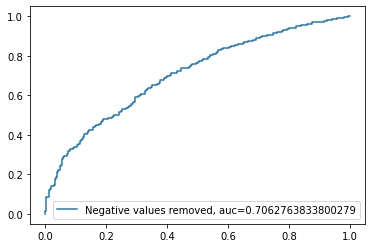

In [283]:

#We are going to undersample
imbalanced_X_negrem = X_train_negrm
imbalanced_Y_negrem = y_train_negrm

#Sampling the number of y=0 from subset where y=1
undersampled_X_negrem, undersampled_Y_negrem = resample(imbalanced_X_negrem[imbalanced_Y_negrem==1], imbalanced_Y_negrem[imbalanced_Y_negrem==1],replace=True,
                n_samples=imbalanced_X_negrem[imbalanced_Y_negrem==0].shape[0],
                random_state=123)

#Create new balanced training set - combine with Y=0
balanced_X_negrem = np.vstack((imbalanced_X_negrem[imbalanced_Y_negrem==0],undersampled_X_negrem))
balanced_Y_negrem = np.hstack((imbalanced_Y_negrem[imbalanced_Y_negrem==0],undersampled_Y_negrem))

balanced_X_negrem = scaler.fit_transform(balanced_X_negrem)
X_valid_negrm = scaler.fit_transform(X_valid_negrm)

model_neg_rem=LogisticRegression(penalty = 'none')

model_neg_rem.fit(balanced_X_negrem, balanced_Y_negrem)
y_pred_proba_negrm = model_neg_rem.predict_proba(X_valid_negrm)[::,1]
fpr_n, tpr_n, _ = metrics.roc_curve(y_valid_negrm,  y_pred_proba_negrm)
auc_neg_rem = metrics.roc_auc_score(y_valid_negrm, y_pred_proba_negrm)
plt.plot(fpr_n,tpr_n,label="Negative values removed, auc="+str(auc_neg_rem))
plt.legend(loc=4)
plt.show()

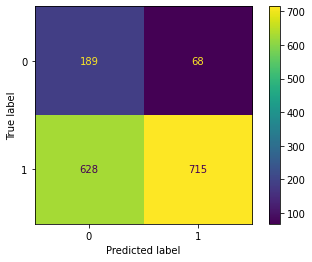

In [284]:
y_negrem_predict =model_neg_rem.predict(X_valid_negrm)
cm_negrem= confusion_matrix(y_valid, y_negrem_predict, labels=model_neg_rem.classes_)

disp_negrem = ConfusionMatrixDisplay(confusion_matrix=cm_negrem, display_labels=model_neg_rem.classes_)
disp_negrem.plot()

Removing negative values slightly increased AUC metric, but reduced the accuracy of predicting rookie lasting more than 5 years to 53%
Impact on AUC metric is minimal but impact on accuracy score is significant.


2. <b> Gradient Boosting </b>

We are now goint to move on to a gradient boost model

In [285]:
#import from scikit learn
from sklearn.ensemble import GradientBoostingClassifier

#Train on undersampled balanced dataset with all features
gb_model = GradientBoostingClassifier(learning_rate=0.01).fit(balanced_X_1, balanced_Y_1)

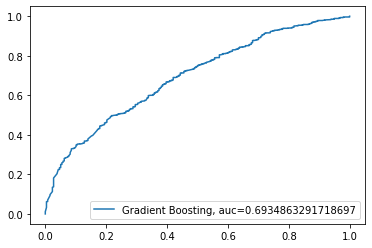

In [286]:
y_pred_proba_gb = gb_model.predict_proba(X_valid)[::,1]
fpr_gb, tpr_gb, _ = metrics.roc_curve(y_valid,  y_pred_proba_gb)
auc_gb = metrics.roc_auc_score(y_valid, y_pred_proba_gb)
plt.plot(fpr_gb,tpr_gb,label="Gradient Boosting, auc="+str(auc_gb))
plt.legend(loc=4)
plt.show()

The gradient boosting model performs similar to the logit model (slight lower AUC though)

In [287]:
gb_model.feature_importances_
pd.DataFrame(np.round(gb_model.feature_importances_,2), index = df_analysis.columns).T

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,0.59,0.0,0.0,0.02,0.0,0.11,0.0,0.0,0.0,0.01,0.05,0.03,0.03,0.01,0.09,0.01,0.02,0.01,0.0


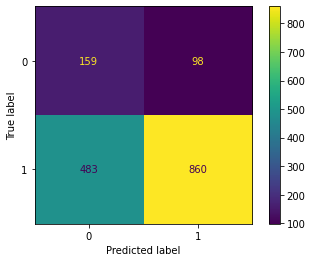

In [288]:
y_gb_predict =gb_model.predict(X_valid)
cm_gb= confusion_matrix(y_valid, y_gb_predict, labels=model_new_reduce.classes_)

disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=gb_model.classes_)
disp_gb.plot()

The feature importance stats also have a similar result to the logit model
GP, FG%, and  rebound stats appear to be key features

We will now re-fit gradient boost model with the highly correlated features removed

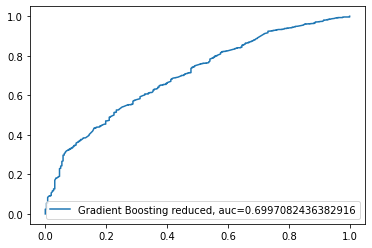

In [289]:
#Train on undersampled balanced dataset
gb_model_reduce = GradientBoostingClassifier(learning_rate=0.01).fit(balanced_X_reduce, balanced_Y_reduce)
y_pred_proba_gbr = gb_model_reduce.predict_proba(X_valid_reduce)[::,1]
fpr_gbr, tpr_gbr, _ = metrics.roc_curve(y_valid_reduce,  y_pred_proba_gbr)
auc_gbr = metrics.roc_auc_score(y_valid_reduce, y_pred_proba_gbr)
plt.plot(fpr_gbr,tpr_gbr,label="Gradient Boosting reduced, auc="+str(auc_gbr))
plt.legend(loc=4)
plt.show()


<AxesSubplot:>

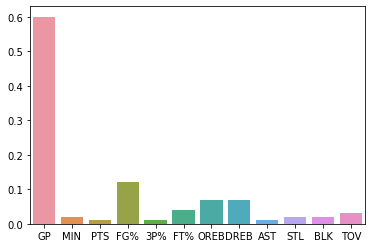

In [290]:
gb_model_reduce.feature_importances_
gb_chart=pd.DataFrame(np.round(gb_model_reduce.feature_importances_,2), index = df_analysis_reduce.columns).T
sns.barplot(data=gb_chart)

Removing correlated features improved AUC score but still slightly less than logit model

The gradient boost model has similar results as the logit model with reduced features

GP, FG%, and rebound stats are important features

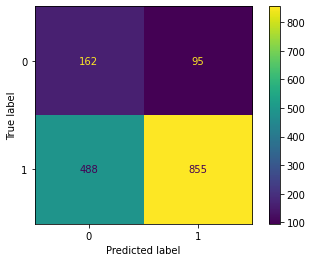

In [291]:
y_gbr_predict =gb_model_reduce.predict(X_valid_reduce)
cm_gbr= confusion_matrix(y_valid, y_gbr_predict, labels=gb_model_reduce.classes_)

disp_gbr = ConfusionMatrixDisplay(confusion_matrix=cm_gbr, display_labels=gb_model_reduce.classes_)
disp_gbr.plot()

3. <b> XGB model </b>

We are now going to try the XGB model

In [292]:
#Train on balanced undersample model with all the features
model_xgb=XGBClassifier(max_depth=3, eta=0.01, reg_lambda=0, use_label_encoder=False)
model_xgb.fit(balanced_X_1, balanced_Y_1, verbose=False)
model_xgb.predict(X_valid)

[21:46:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0, 0, 1, ..., 1, 0, 1])

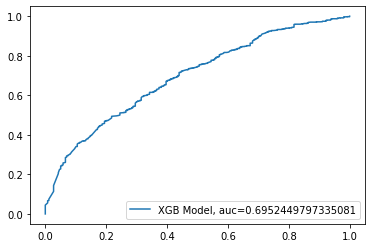

In [293]:
y_pred_proba_xgb = model_xgb.predict_proba(X_valid)[::,1]
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_valid,  y_pred_proba_xgb)
auc_xgb = metrics.roc_auc_score(y_valid, y_pred_proba_xgb)
plt.plot(fpr_xgb,tpr_xgb,label="XGB Model, auc="+str(auc_xgb))
plt.legend(loc=4)
plt.show()

In [294]:
model_xgb.feature_importances_
pd.DataFrame(np.round(model_xgb.feature_importances_,2), index = df_analysis.columns).T


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,0.18,0.04,0.03,0.05,0.04,0.05,0.0,0.01,0.02,0.03,0.07,0.04,0.05,0.16,0.06,0.03,0.03,0.05,0.05


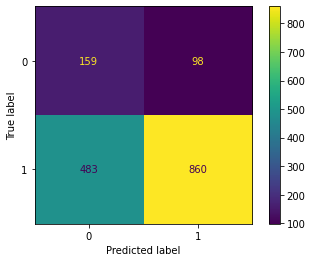

In [295]:
y_xgb_predict =model_xgb.predict(X_valid)
cm_xgb= confusion_matrix(y_valid, y_xgb_predict, labels=model_xgb.classes_)

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=model_xgb.classes_)
disp_xgb.plot()

The XGB model performs slightly better than the GB model but slightly less than logit model 

Unlike Logit and GB models, it predicts GP and defensive rebound as important features (not FG%)

We are now going to try the XGB model with the highly correlated values removed

In [315]:
#Try XGBModel reduced model with balanced undersampled dataset
model_xgb_reduce=XGBClassifier(max_depth=3, eta=0.01, reg_lambda=0, use_label_encoder=False)
model_xgb_reduce.fit(balanced_X_reduce, balanced_Y_reduce, verbose=False)
model_xgb_reduce.predict(X_valid_reduce)

[22:14:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0, 0, 1, ..., 1, 0, 1])

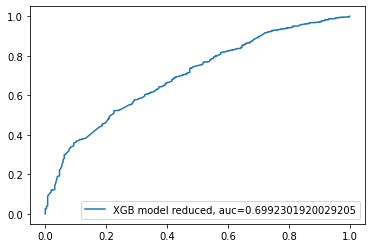

In [316]:
y_pred_proba_xgbr = model_xgb_reduce.predict_proba(X_valid_reduce)[::,1]
fpr_xgbr, tpr_xgbr, _ = metrics.roc_curve(y_valid_reduce,  y_pred_proba_xgbr)
auc_xgbr = metrics.roc_auc_score(y_valid_reduce, y_pred_proba_xgbr)
plt.plot(fpr_xgbr,tpr_xgbr,label="XGB model reduced, auc="+str(auc_xgbr))
plt.legend(loc=4)
plt.show()

<AxesSubplot:>

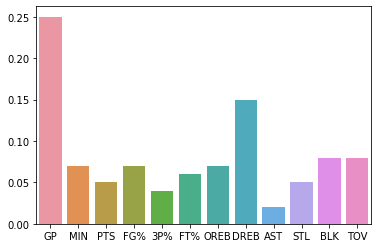

In [317]:
model_xgb_reduce.feature_importances_
xgbr_data=pd.DataFrame(np.round(model_xgb_reduce.feature_importances_,2), index = df_analysis_reduce.columns).T
sns.barplot(data=xgbr_data)


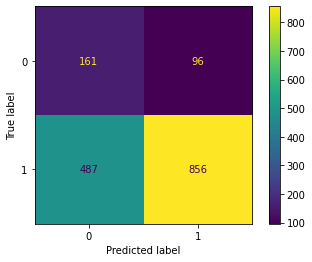

In [318]:
y_xgbr_predict =model_xgb_reduce.predict(X_valid_reduce)
cm_xgbr= confusion_matrix(y_valid, y_xgbr_predict, labels=model_xgb_reduce.classes_)

disp_xgbr = ConfusionMatrixDisplay(confusion_matrix=cm_xgbr, display_labels=model_xgb_reduce.classes_)
disp_xgbr.plot()

The xgb model performs slightly worse than the gb model and logit with correlated features removed

Unlike gbmodel and logit model, the xgb model predicts defensive rebound to be a more important feature than %FG


<b> Summary </b>

In [303]:
summary=pd.DataFrame(np.array([auc_reduce, auc_gb, auc_gbr, auc_xgb, auc_xgbr]), index=("Logit correlated features removed", "Gradient boost", "Gradient boost correlated values removed","XGB","XGB correlated features removed"))
summary.rename(columns={0:'AUC'}, inplace=True)
summary

,AUC
Logit correlated features removed,0.705239
Gradient boost,0.693486
Gradient boost correlated values removed,0.699708
XGB,0.695245
XGB correlated features removed,0.699230


* Removing correlated features improved AUC metric for XGB and Gradient Boost models.
however these models do not appear to be much different from logit model in terms of AUC metric peformance 

Logit has better interpretability than GB and XGB and can show the direction of a feature's influence


<b> Next steps: </b>
    
* Tune hyperparemeters in Logit model
- investigate 'class_weight' parameter

* Investigate Random Forest and SVC models with inbuilt adjustment for imbalanced dataset


In [335]:
#Preparing files for Kaggle Submissions
#Grab the test data
test_data=pd.read_csv('../data/raw/test.csv')
test_data_model = test_data.drop(columns=["Id_old","Id"])

In [336]:
#prediction for models with correlated features removed
test_data_model_red = test_data_model.drop(columns=["FGM","FGA","3P Made","3PA","FTM","FTA","REB"])
test_data_model_red_scaled=scaler.fit_transform(test_data_model_red)

model_new_reduce_predprob = model_new_reduce.predict_proba(test_data_model_red_scaled)[:,1]
submission_file_reduce = pd.DataFrame(model_new_reduce_predprob, index=test_data['Id'])

submission_file_reduce.rename( columns={0 :'TARGET_5Yrs'}, inplace=True )
submission_file_reduce.to_csv('../data/processed/lg_model_reduced.csv' )

In [337]:
gb_model_reduce_predprob = gb_model_reduce.predict_proba(test_data_model_red_scaled)[:,1]
submission_file_gbreduce = pd.DataFrame(gb_model_reduce_predprob, index=test_data['Id'])

submission_file_gbreduce.rename( columns={0 :'TARGET_5Yrs'}, inplace=True )
submission_file_gbreduce.to_csv('../data/processed/gb_model_reduced.csv' )


In [338]:
model_xgb_reduce_predprob = model_xgb_reduce.predict_proba(test_data_model_red_scaled)[:,1]
submission_file_xgbreduce = pd.DataFrame(model_xgb_reduce_predprob, index=test_data['Id'])

submission_file_xgbreduce.rename( columns={0 :'TARGET_5Yrs'}, inplace=True )
submission_file_xgbreduce.to_csv('../data/processed/xgb_model_reduced.csv' )

In [339]:
#Predictions for model with correlated features not removed
test_data_model_scaled=scaler.fit_transform(test_data_model)
gb_model_predprob = gb_model.predict_proba(test_data_model_scaled)[:,1]
submission_file_gb = pd.DataFrame(gb_model_predprob, index=test_data['Id'])

submission_file_gb.rename( columns={0 :'TARGET_5Yrs'}, inplace=True )
submission_file_gb.to_csv('../data/processed/gb_model.csv' )

In [340]:
model_xgb_predprob = model_xgb.predict_proba(test_data_model_scaled)[:,1]
submission_file_xgb = pd.DataFrame(model_xgb_predprob, index=test_data['Id'])

submission_file_xgb.rename( columns={0 :'TARGET_5Yrs'}, inplace=True )
submission_file_xgb.to_csv('../data/processed/xgb_model.csv' )